<h1> Curso de Spark </h1>
<h2> Organizado por Grupo TARO de ULL </h2>
<h3> Ponentes: José L. Roda, Marcos Colebrook, Carlos Pérez </h3>
<h5> (profesores del itinerario de Ingeniería del Software en Máster de Ingeniería Informática de ULL) </h5>


<h2> Ejemplo práctico I: Conteo de palabras en archivos </h2>
<a href="http://www.gutenberg.org/wiki/Main_Page">
<img align=left src="images/cosette.jpg" width=200 height=200 />
</a>

In [2]:
from pyspark import SparkContext
sc =SparkContext()
sc

In [3]:
book = sc.textFile('los_miserables/')

In [4]:
book.count()

68120

In [19]:
lines_nonempty = book.filter( lambda x: len(x) > 0 )

In [20]:
lines_nonempty.count()

52973

In [29]:
#flatMap applies a function which takes each input value and returns a list. 
#Each value of the list becomes a new, separate value in the output RDD
words = lines_nonempty.flatMap(lambda x: x.split())
words.take(5)

[u'VOLUME', u'III--MARIUS.', u'[Illustration:', u'Frontispiece', u'Volume']

In [30]:
# We use a function which replaces each original value in the input RDD 
# with a 2-tuple containing the word in the first position and the integer value 1 
# in the second position
wordcounts1 = words.map(lambda x: (x, 1))  
wordcounts1.take(5)

[(u'VOLUME', 1),
 (u'III--MARIUS.', 1),
 (u'[Illustration:', 1),
 (u'Frontispiece', 1),
 (u'Volume', 1)]

In [31]:
# It is expected that the input RDD contains tuples of the form (<key>,<value>). 
# Create a new RDD containing a tuple for each unique value of <key> in the input, 
# where the value in the second position of the tuple is created by applying 
# the supplied lambda function to the <value>s with the matching <key> in the input RDD
wordcounts2=wordcounts1.reduceByKey(lambda x,y:x+y)
wordcounts2.take(5)

[(u'texts:', 1),
 (u'instinctive,', 1),
 (u'shouted.', 2),
 (u'yellow', 42),
 (u'clotted', 1)]

In [32]:
# map a lambda function to the data which will swap over the first and second values 
# in each tuple, now the word count appears in the first 
wordcounts3=wordcounts2.map(lambda x:(x[1],x[0])) 
wordcounts3.take(5)

[(1, u'texts:'),
 (1, u'instinctive,'),
 (2, u'shouted.'),
 (42, u'yellow'),
 (1, u'clotted')]

In [33]:
#sort the input RDD by the key value (the value at the first position in each tuple)
#the False parameter sets the sort order to descending
wordcounts4 = wordcounts3.sortByKey(ascending=False)
wordcounts4.take(5)

[(36588, u'the'),
 (19666, u'of'),
 (13819, u'and'),
 (13480, u'a'),
 (13305, u'to')]

In [ ]:
#all last instructions in only one
wordcounts = words.map(lambda x: (x, 1)) \
                  .reduceByKey(lambda x,y:x+y) \
                  .map(lambda x:(x[1],x[0])) 

<h2> Ejemplo práctico II: Alertas del servicio 112 </h2>
<a href="http://www.112canarias.com/info">
<img align=left src="files/images/procesollamada_001.jpg" width=200 height=200 />
</a>

In [5]:
alertas=sc.textFile("112/alertas112.txt")

In [6]:
alertas.count()

100001

In [8]:
alertas.take(5)

[u'ANIO;MINICIO;MES;CODSEXO;CODMUN;MUN112;PROV;ISLA;RECURSO;FRECURSO',
 u'2008;08;Agosto;;35016;Las Palmas;Las Palmas;Gran Canaria;Policia Local;Informacion sin Seguimiento',
 u'2005;10;Octubre;Ho;35016;Las Palmas;Las Palmas;Gran Canaria;NA;NA',
 u'2005;02;Febrero;Mu;35016;Las Palmas;Las Palmas;Gran Canaria;NA;NA',
 u'2005;09;Septiembre;Mu;38038;Santa Cruz de Tenerife;Tenerife;Tenerife;Policia Local;Actuaci\xf3n in situ']

In [9]:
header = alertas.first() #extract header
alertas = alertas.filter(lambda x:x !=header)    #filter out header
alertas.take(5)

[u'2008;08;Agosto;;35016;Las Palmas;Las Palmas;Gran Canaria;Policia Local;Informacion sin Seguimiento',
 u'2005;10;Octubre;Ho;35016;Las Palmas;Las Palmas;Gran Canaria;NA;NA',
 u'2005;02;Febrero;Mu;35016;Las Palmas;Las Palmas;Gran Canaria;NA;NA',
 u'2005;09;Septiembre;Mu;38038;Santa Cruz de Tenerife;Tenerife;Tenerife;Policia Local;Actuaci\xf3n in situ',
 u'2009;11;Noviembre;;35002;Ag\xfcimes;Las Palmas;Gran Canaria;Policia Local;Informacion sin Seguimiento']

In [7]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [8]:
!pwd

/home/jovyan/work/extrainfo2017/tema04


In [9]:
df = sqlContext.read.format('com.databricks.spark.csv') \
                    .options(header='true', inferschema='true', delimiter=';') \
                    .load('file:///home/jovyan/work/extrainfo2017/tema04/112/alertas112.txt')
#df = sqlContext.read.format('com.databricks.spark.csv') \
#                    .options(header='true', inferschema='true', delimiter=';') \
#                    .load('alertas112_red.txt')

In [13]:
df.printSchema()

root
 |-- ANIO: integer (nullable = true)
 |-- MINICIO: integer (nullable = true)
 |-- MES: string (nullable = true)
 |-- CODSEXO: string (nullable = true)
 |-- CODMUN: integer (nullable = true)
 |-- MUN112: string (nullable = true)
 |-- PROV: string (nullable = true)
 |-- ISLA: string (nullable = true)
 |-- RECURSO: string (nullable = true)
 |-- FRECURSO: string (nullable = true)



In [14]:
df.show(5)

+----+-------+----------+-------+------+--------------------+----------+------------+-------------+--------------------+
|ANIO|MINICIO|       MES|CODSEXO|CODMUN|              MUN112|      PROV|        ISLA|      RECURSO|            FRECURSO|
+----+-------+----------+-------+------+--------------------+----------+------------+-------------+--------------------+
|2008|      8|    Agosto|   null| 35016|          Las Palmas|Las Palmas|Gran Canaria|Policia Local|Informacion sin S...|
|2005|     10|   Octubre|     Ho| 35016|          Las Palmas|Las Palmas|Gran Canaria|           NA|                  NA|
|2005|      2|   Febrero|     Mu| 35016|          Las Palmas|Las Palmas|Gran Canaria|           NA|                  NA|
|2005|      9|Septiembre|     Mu| 38038|Santa Cruz de Ten...|  Tenerife|    Tenerife|Policia Local|   Actuación in situ|
|2009|     11| Noviembre|   null| 35002|             Agüimes|Las Palmas|Gran Canaria|Policia Local|Informacion sin S...|
+----+-------+----------+-------

In [12]:
df_by_anio=df.groupBy("ANIO").count()
df_by_anio.show()

+----+-----+
|ANIO|count|
+----+-----+
|2007| 9839|
|2006| 9766|
|2013| 9627|
|2014| 9978|
|2012|10425|
|2009|10450|
|2005| 9472|
|2010|10108|
|2011|10136|
|2008|10199|
+----+-----+



In [28]:
df_by_anio.head(5)

[Row(ANIO=2007, count=9839),
 Row(ANIO=2006, count=9766),
 Row(ANIO=2013, count=9627),
 Row(ANIO=2014, count=9978),
 Row(ANIO=2012, count=10425)]

In [17]:
df_by_anio.select('ANIO').head(5)

[Row(ANIO=2007),
 Row(ANIO=2006),
 Row(ANIO=2013),
 Row(ANIO=2014),
 Row(ANIO=2012)]

In [18]:
#https://databricks.com/blog/2015/08/12/from-pandas-to-apache-sparks-dataframe.html
df_by_anio.select(df_by_anio.ANIO > 2009).show()

+-------------+
|(ANIO > 2009)|
+-------------+
|        false|
|        false|
|         true|
|         true|
|         true|
|        false|
|        false|
|         true|
|         true|
|        false|
+-------------+



In [19]:
df_by_anio_ampliado=df_by_anio.withColumn('filter_anio', df_by_anio.ANIO > 2009)
df_by_anio_ampliado.show()

+----+-----+-----------+
|ANIO|count|filter_anio|
+----+-----+-----------+
|2007| 9839|      false|
|2006| 9766|      false|
|2013| 9627|       true|
|2014| 9978|       true|
|2012|10425|       true|
|2009|10450|      false|
|2005| 9472|      false|
|2010|10108|       true|
|2011|10136|       true|
|2008|10199|      false|
+----+-----+-----------+



In [20]:
df_by_anio_ampliado[df_by_anio_ampliado.filter_anio == True].show()

+----+-----+-----------+
|ANIO|count|filter_anio|
+----+-----+-----------+
|2013| 9627|       true|
|2014| 9978|       true|
|2012|10425|       true|
|2010|10108|       true|
|2011|10136|       true|
+----+-----+-----------+



In [21]:
#en resumen
df_by_anio[df_by_anio.ANIO>2009].show()

+----+-----+
|ANIO|count|
+----+-----+
|2013| 9627|
|2014| 9978|
|2012|10425|
|2010|10108|
|2011|10136|
+----+-----+



<h4> Operaciones estadísticas </h4>

In [13]:
df_by_anio.describe('count').show()

+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|               10|
|   mean|          10000.0|
| stddev|325.2281250650587|
|    min|             9472|
|    max|            10450|
+-------+-----------------+



In [14]:
#https://spark.apache.org/docs/1.6.0/api/python/_modules/pyspark/sql/functions.html
from pyspark.sql.functions import mean, min, max
df_by_anio.select([mean('count'), min('count'), max('count')]).show()

+----------+----------+----------+
|avg(count)|min(count)|max(count)|
+----------+----------+----------+
|   10000.0|      9472|     10450|
+----------+----------+----------+



In [24]:
df_by_anio_ampliado=df_by_anio.withColumn("count_divided_by_12",df_by_anio["count"]/12)
df_by_anio_ampliado.show()

+----+-----+-------------------+
|ANIO|count|count_divided_by_12|
+----+-----+-------------------+
|2007| 9839|  819.9166666666666|
|2006| 9766|  813.8333333333334|
|2013| 9627|             802.25|
|2014| 9978|              831.5|
|2012|10425|             868.75|
|2009|10450|  870.8333333333334|
|2005| 9472|  789.3333333333334|
|2010|10108|  842.3333333333334|
|2011|10136|  844.6666666666666|
|2008|10199|  849.9166666666666|
+----+-----+-------------------+



In [25]:
#https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html
#Cross Tabulation
df.stat.crosstab("ANIO", "CODSEXO").show()

+------------+----+----+----+
|ANIO_CODSEXO|  Ho|  Mu|null|
+------------+----+----+----+
|        2014|3073|3058|3847|
|        2010|2966|2819|4323|
|        2007|3175|2872|3792|
|        2011|3044|2889|4203|
|        2006|3103|2721|3942|
|        2005|3087|2717|3668|
|        2012|3270|3176|3979|
|        2013|3048|2826|3753|
|        2009|3209|3087|4154|
|        2008|3096|2827|4276|
+------------+----+----+----+



In [26]:
#Frequent Items
freq = df.stat.freqItems(["RECURSO"], 0.4)  #finds the frequent items that show up 60% 
                                            #of the time for each column
freq.collect()

[Row(RECURSO_freqItems=[u'Ambulancia SVB', u'Policia Local'])]

<h4> Convirtiendo dataframe a Pandas </h4>

In [17]:
df_anio=df_by_anio.toPandas()
df_anio

,ANIO,count
0,2007,9839
1,2006,9766
2,2013,9627
3,2014,9978
4,2012,10425
5,2009,10450
6,2005,9472
7,2010,10108
8,2011,10136
9,2008,10199


In [18]:
df_anio.head(5)

,ANIO,count
0,2007,9839
1,2006,9766
2,2013,9627
3,2014,9978
4,2012,10425


In [19]:
df_anio.tail(5)

,ANIO,count
5,2009,10450
6,2005,9472
7,2010,10108
8,2011,10136
9,2008,10199


In [20]:
df_anio[['count']].describe()

,count
count,10.000000
mean,10000.000000
std,325.228125
min,9472.000000
25%,9784.250000
50%,10043.000000
75%,10183.250000
max,10450.000000


In [21]:
df_anio["count_divided_by_12"]=df_anio["count"]/12
df_anio

,ANIO,count,count_divided_by_12
0,2007,9839,819.916667
1,2006,9766,813.833333
2,2013,9627,802.250000
3,2014,9978,831.500000
4,2012,10425,868.750000
5,2009,10450,870.833333
6,2005,9472,789.333333
7,2010,10108,842.333333
8,2011,10136,844.666667
9,2008,10199,849.916667


<h4> Visualización gráfica </h4>

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


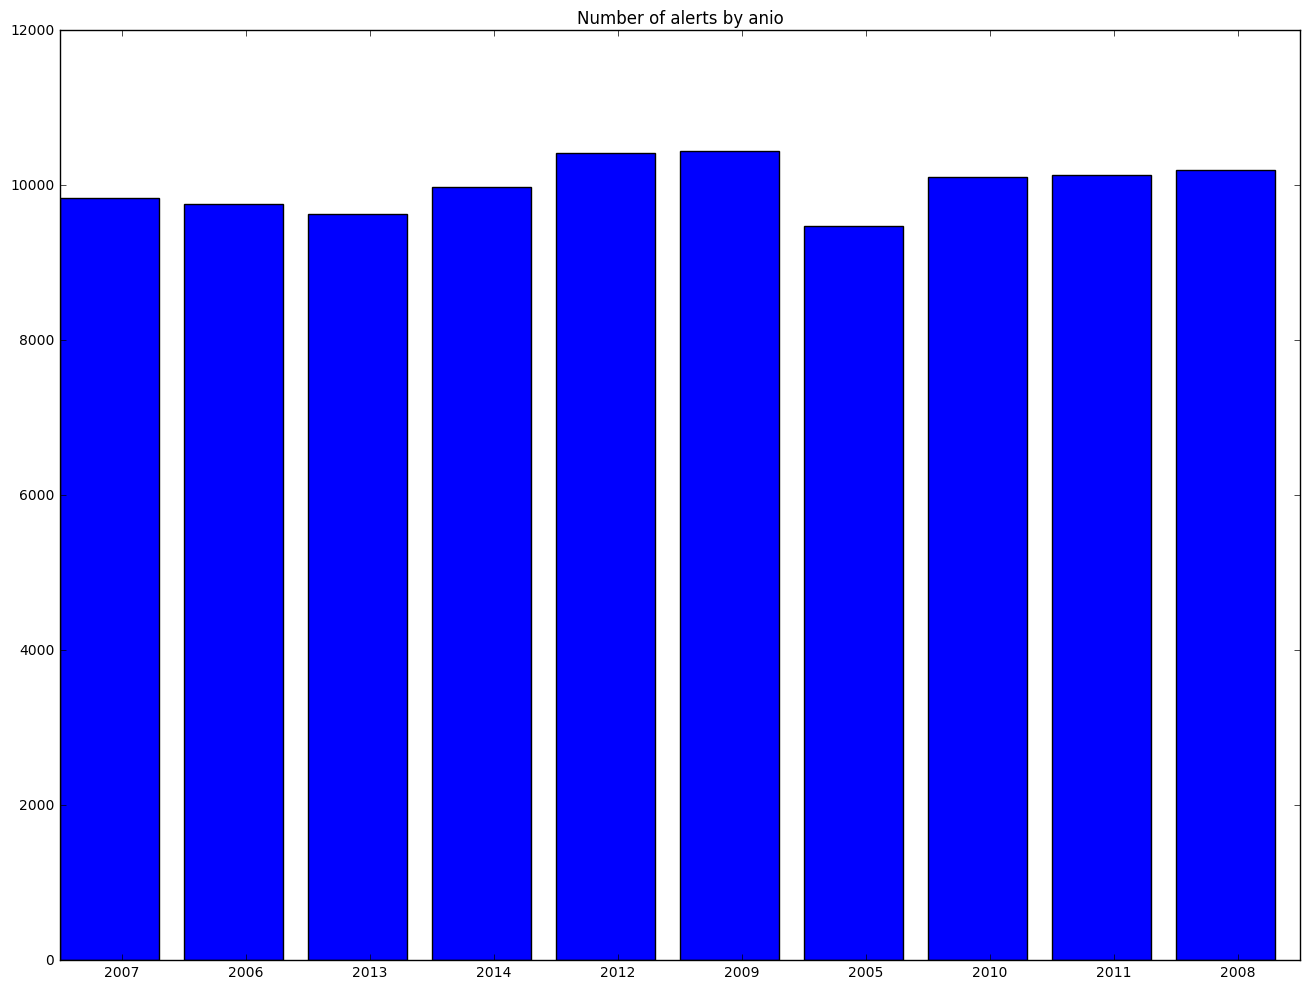

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

values = df_anio["count"]
anios = df_anio["ANIO"]

plt.gcf().set_size_inches(16, 12, forward=True)
plt.title('Number of alerts by anio')

plt.bar(range(len(values)), values)
plt.xticks([i+0.5 for i in range(len(values))], anios)

plt.show()

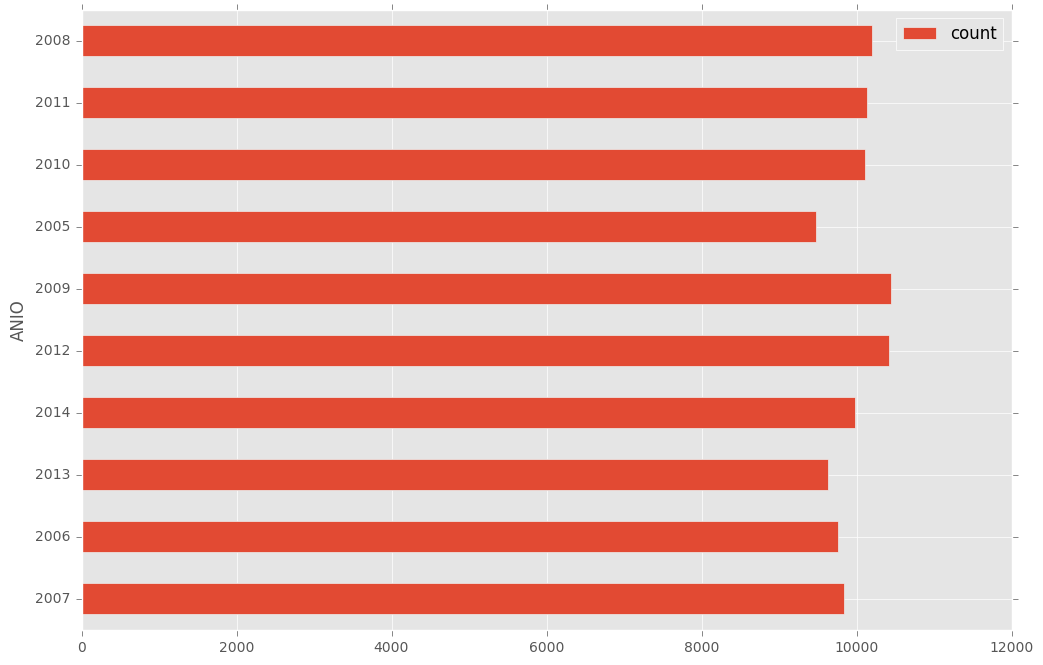

In [23]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

df_anio.plot(
  kind='barh', 
  x='ANIO',
  y='count',
  figsize=(12, 8)
)